In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

## Introduction

Many of the online Hotel Booking sites like Expedia, Booking.com, TripAdvisor use machine learning approach to personalize the hotels for each user. This is done based on a number of factors like hotel location, user past purchase history, hotel features and competitor’s features. After evaluating all these factors, a list of hotels is presented to user based on his/her search parameters. 
In this project what we will try to achieve is that how accurately we are able to predict the Click-through for a particular hotel search result. Click-through means if a user clicks a hotel listing or not. The techniques used for this project will be classification algorithms like Logistic, Classification tree, Random Forests, Boosting, Naive Bayes and Neural Network. All of the model accuracy scores will be compared against each other to see which one gives the highest out-of-sample accuracy.
However, the exploratory data analysis part is equally important as the model results. Through, Exploratory Data Analysis we will try to answer what are the major factors that influence user’s decision to click on a hotel listing. Is it because of lower price? Or due to property location? Or maybe because it has higher ratings?
Combining both of our analysis, the final results will be presented showing the key factors influencing click-through and final model accuracy on predicting the click-through of those listings.


## Data Wrangling

In [2]:
df = pd.read_csv('data/train.csv')
df.shape

(9917530, 54)

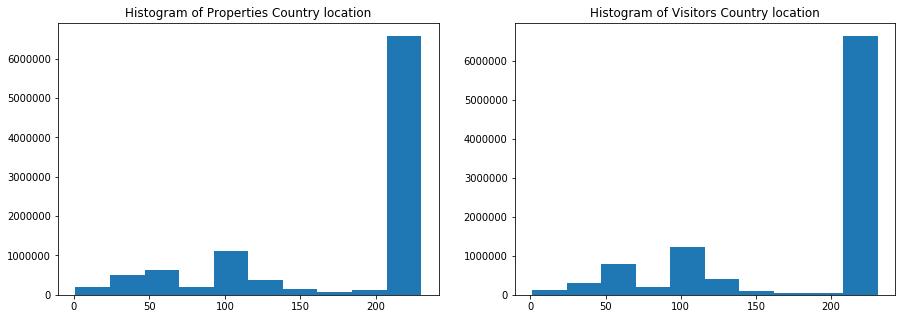

In [3]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(df.prop_country_id)
ax[0].set_title('Histogram of Properties Country location')
ax[1].hist(df.visitor_location_country_id)
ax[1].set_title('Histogram of Visitors Country location');

Focusing only on US

In [4]:
df.groupby('prop_country_id').size().nlargest(5)

prop_country_id
219    6052976
100     622810
55      376219
31      309434
99      268393
dtype: int64

In [5]:
df.groupby('visitor_location_country_id').size().nlargest(5)

visitor_location_country_id
219    5778805
100     990487
55      580072
216     434568
220     350433
dtype: int64

In [6]:
us1 = df.loc[(df['visitor_location_country_id'] == 219) & (df['prop_country_id'] == 219)]

In [7]:
us1.shape

(5036079, 54)

In [8]:
us2 = us1.sample(frac=0.6, random_state=100)
del us2['visitor_location_country_id'],us2['prop_country_id']

In [9]:
us2.shape

(3021647, 52)

In [10]:
us = df.loc[df['visitor_location_country_id'] == 219]

In [11]:
us = us.sample(frac=0.6, random_state=100)
del us['visitor_location_country_id']

In [12]:
us.shape

(3467283, 53)

In [13]:
us.isnull().sum()

srch_id                            0
date_time                          0
site_id                            0
visitor_hist_starrating      3325707
visitor_hist_adr_usd         3324976
prop_country_id                    0
prop_id                            0
prop_starrating                    0
prop_review_score               3294
prop_brand_bool                    0
prop_location_score1               0
prop_location_score2          804536
prop_log_historical_price          0
position                           0
price_usd                          0
promotion_flag                     0
srch_destination_id                0
srch_length_of_stay                0
srch_booking_window                0
srch_adults_count                  0
srch_children_count                0
srch_room_count                    0
srch_saturday_night_bool           0
srch_query_affinity_score    3174822
orig_destination_distance     432222
random_bool                        0
comp1_rate                   3425308
c

In [14]:
def missing_values(df):
    miss_summary = pd.DataFrame(columns=['variable','missing_values', 'missing_%'])
    columns = df.columns
    for col in columns:
        col_name = col
        count = df[col].isnull().sum()
        percentage = round((df[col].isna().sum()/df[col].shape[0])*100,2)
        miss_summary.loc[len(miss_summary)] = [col_name, count, percentage]
        miss_summary.sort_values('missing_values',ascending=False,inplace=True)
    return(miss_summary[miss_summary['missing_%'] > 0])


Removing the missing values where missing percent is greater than 70

In [15]:
missdf = missing_values(us2)
missdf.to_clipboard(sep=',')

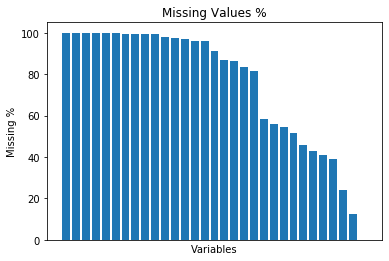

In [16]:
plt.bar('variable','missing_%',data=missdf)
plt.xlabel('Variables')
plt.ylabel('Missing %')
plt.title('Missing Values %')
plt.xticks([])
plt.show();

In [17]:
cols_to_drop = ['date_time', 'visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score', 'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate', 'comp2_inv', 'comp3_inv', 'comp4_inv', 'comp5_inv', 'comp6_inv', 'comp7_inv', 'comp8_inv', 'gross_bookings_usd', 'srch_id', 'prop_id']
us2.drop(cols_to_drop, axis=1, inplace=True)

In [18]:
missing_values(us2)

,variable,missing_values,missing_%
5,prop_location_score2,721461,23.88
17,orig_destination_distance,379844,12.57
2,prop_review_score,2320,0.08


In [19]:
import random
def randomiseMissingData(df2):
    "randomise missing data for DataFrame (within a column)"
    df = df2.copy()
    for col in df.columns:
        data = df['prop_review_score']
        mask = data.isnull()
        samples = random.choices( data[~mask].values , k = mask.sum() )
        data[mask] = samples
    return df
us3 = randomiseMissingData(us2)

In [20]:
us3['prop_location_score2'].fillna((us3['prop_location_score2'].mean()), inplace=True)

In [21]:
us3['orig_destination_distance'].fillna((us3['orig_destination_distance'].median()), inplace=True)

In [22]:
us3.shape

(3021647, 21)

In [23]:
finalDf = us3.copy()

## Exploratory Data Analysis

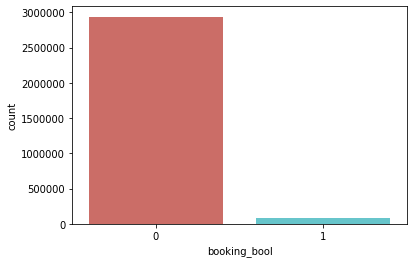

0    2935918
1      85729
Name: booking_bool, dtype: int64

In [24]:
sns.countplot(x='booking_bool',data=finalDf, palette='hls')
plt.show();
finalDf['booking_bool'].value_counts()

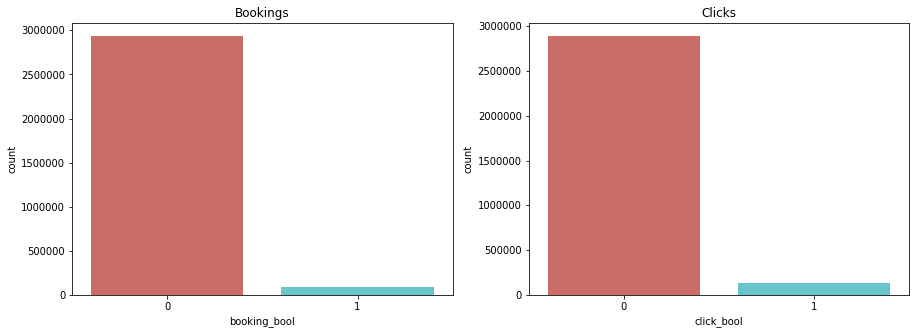

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.countplot(x='booking_bool',data=finalDf, palette='hls',ax=ax1)
ax1.set_title('Bookings')
sns.countplot(x='click_bool',data=finalDf, palette='hls',ax=ax2)
ax2.set_title('Clicks');

In [26]:
finalDf['click_bool'].value_counts()

0    2892054
1     129593
Name: click_bool, dtype: int64

In [27]:
finalDf.dtypes

site_id                        int64
prop_starrating                int64
prop_review_score            float64
prop_brand_bool                int64
prop_location_score1         float64
prop_location_score2         float64
prop_log_historical_price    float64
position                       int64
price_usd                    float64
promotion_flag                 int64
srch_destination_id            int64
srch_length_of_stay            int64
srch_booking_window            int64
srch_adults_count              int64
srch_children_count            int64
srch_room_count                int64
srch_saturday_night_bool       int64
orig_destination_distance    float64
random_bool                    int64
click_bool                     int64
booking_bool                   int64
dtype: object

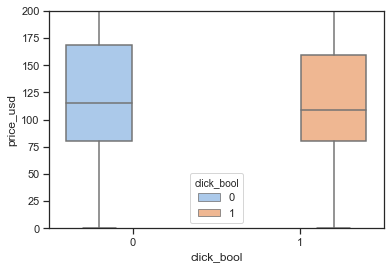

In [28]:
sns.set(style="ticks", palette="pastel")
ax = sns.boxplot(x="click_bool", y="price_usd", hue="click_bool", data=finalDf)
ax.set_ylim([0, 200]);

In [29]:
finalDf.head()

,site_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,...,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,click_bool,booking_bool
522939,5,2,3.0,1,1.61,0.003400,4.37,34,60.0,0,...,1,1,2,0,1,1,360.92,0,0,0
1412106,5,2,4.0,1,1.39,0.122496,4.31,4,56.0,0,...,1,9,2,0,1,1,255.41,0,0,0
3581335,5,2,3.5,1,0.00,0.122496,4.60,24,89.0,0,...,1,218,1,0,1,0,362.90,0,0,0
4214837,5,4,4.0,1,5.48,0.037500,5.75,12,251.0,1,...,1,9,2,0,1,1,67.05,0,0,0
15092,5,4,4.0,1,4.01,0.164200,5.60,3,239.0,0,...,1,12,1,0,1,1,82.74,0,0,0


In [30]:
clickedDf = finalDf[finalDf['click_bool'] == 1]
notclickedDf = finalDf[finalDf['click_bool'] == 0]

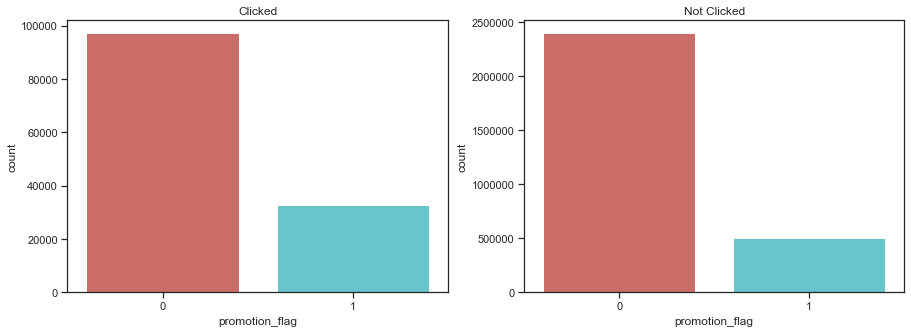

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.countplot(x='promotion_flag',data=clickedDf, palette='hls',ax = ax1)
ax1.set_title('Clicked')
sns.countplot(x='promotion_flag',data=notclickedDf, palette='hls',ax = ax2)
ax2.set_title('Not Clicked');

In [32]:
finalDf.groupby(["promotion_flag","click_bool"]).size()

promotion_flag  click_bool
0               0             2392528
                1               97045
1               0              499526
                1               32548
dtype: int64

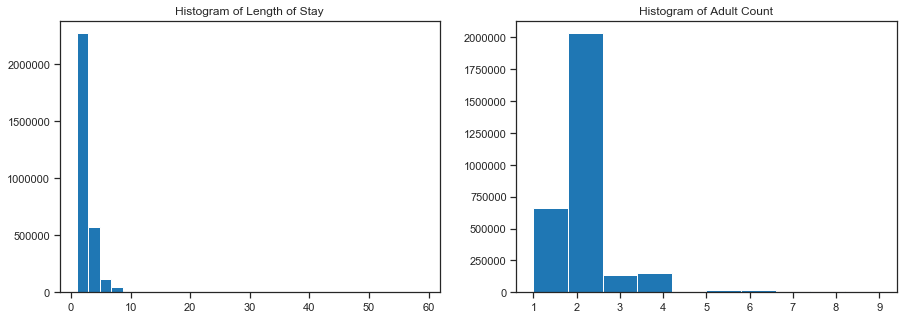

In [33]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(finalDf.srch_length_of_stay,bins = 30,facecolor='#1f77b4')
ax[0].set_title('Histogram of Length of Stay')
ax[1].hist(finalDf.srch_adults_count,facecolor='#1f77b4')
ax[1].set_title('Histogram of Adult Count');

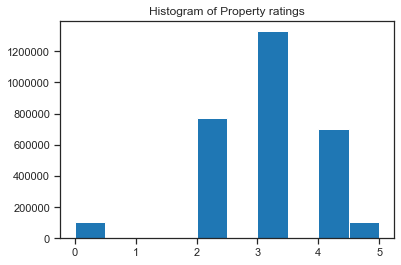

In [34]:
plt.hist(finalDf.prop_starrating,facecolor='#1f77b4')
plt.title('Histogram of Property ratings');

Impute Missing Values

In [35]:
finalDf['prop_location_score2'].describe()

count    3.021647e+06
mean     1.224957e-01
std      1.314944e-01
min      0.000000e+00
25%      2.850000e-02
50%      1.175000e-01
75%      1.241000e-01
max      1.000000e+00
Name: prop_location_score2, dtype: float64

In [40]:
finalDf.isnull().sum()

site_id                      0
prop_starrating              0
prop_review_score            0
prop_brand_bool              0
prop_location_score1         0
prop_location_score2         0
prop_log_historical_price    0
position                     0
price_usd                    0
promotion_flag               0
srch_destination_id          0
srch_length_of_stay          0
srch_booking_window          0
srch_adults_count            0
srch_children_count          0
srch_room_count              0
srch_saturday_night_bool     0
orig_destination_distance    0
random_bool                  0
click_bool                   0
booking_bool                 0
dtype: int64

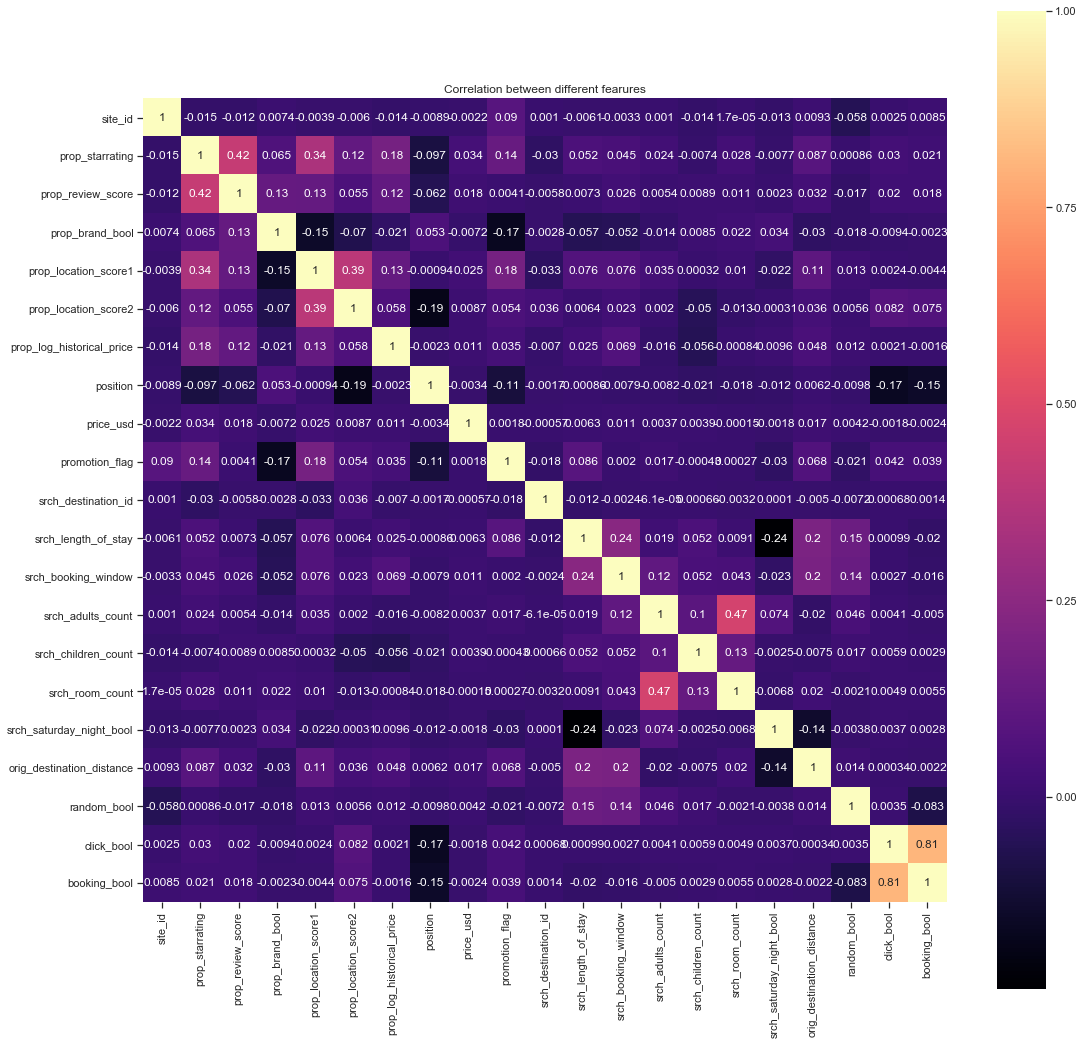

In [100]:
correlation = finalDf.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='magma')
plt.title('Correlation between different fearures');

There are couple of predictor variables which are correlated among themselves. It may lead to the issue of multicollinearity.

### Balancing the Data
Since the response variable is quite undersampled, we have to find ways to balance this variable.(downsampling the negative instances)

In [107]:
import numpy as np

click_indices = finalDf[finalDf.click_bool == 1].index
random_indices = np.random.choice(click_indices, len(finalDf.loc[finalDf.click_bool == 1]), replace=False)
click_sample = finalDf.loc[random_indices]

not_click = finalDf[finalDf.click_bool == 0].index
random_indices = np.random.choice(not_click, sum(finalDf['click_bool']), replace=False)
not_click_sample = finalDf.loc[random_indices]

finalDf_new = pd.concat([not_click_sample, click_sample], axis=0)

print("Percentage of not click impressions: ", len(finalDf_new[finalDf_new.click_bool == 0])/len(finalDf_new))
print("Percentage of click impression: ", len(finalDf_new[finalDf_new.click_bool == 1])/len(finalDf_new))
print("Total number of records in resampled data: ", len(finalDf_new))

Percentage of not click impressions:  0.5
Percentage of click impression:  0.5
Total number of records in resampled data:  259186


## Modeling

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from keras import Sequential
from keras.layers import Dense

In [102]:
finalDf_new.dtypes

site_id                        int64
prop_starrating                int64
prop_review_score            float64
prop_brand_bool                int64
prop_location_score1         float64
prop_location_score2         float64
prop_log_historical_price    float64
position                       int64
price_usd                    float64
promotion_flag                 int64
srch_destination_id            int64
srch_length_of_stay            int64
srch_booking_window            int64
srch_adults_count              int64
srch_children_count            int64
srch_room_count                int64
srch_saturday_night_bool       int64
orig_destination_distance    float64
random_bool                    int64
dtype: object

In [108]:
mms = MinMaxScaler()
finalDf_new = finalDf_new.drop(['site_id','srch_destination_id'],1)
num_cols = finalDf_new.columns[finalDf_new.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
finalDf_new[num_cols] = mms.fit_transform(finalDf_new[num_cols])

In [109]:
Y1=finalDf_new['click_bool'].as_matrix()
Y2=finalDf_new['booking_bool'].as_matrix()
finalDf_new=finalDf_new.drop(['click_bool','booking_bool'], 1)
X=finalDf_new.as_matrix()

In [110]:
np.isnan(np.sum(X))

False

In [111]:
X_train,X_test,y_train,y_test = train_test_split(X,Y1,test_size=0.3,random_state=7)

### Click-Through Prediction with Traditional and Ensemble Models

In [112]:
def get_traditional_models():
    logit = LogisticRegression(solver='liblinear', random_state=10)
    clf = DecisionTreeClassifier(criterion= 'gini', max_depth= 12, min_samples_split = 80)
    rf =RandomForestClassifier(min_samples_leaf=5,min_samples_split=3,max_depth= 12)
    bagg = BaggingClassifier(random_state=10)
    extra = ExtraTreesClassifier(random_state=10)
    ada = AdaBoostClassifier(random_state=10)
    grad = GradientBoostingClassifier(random_state=10)
    xgb = XGBClassifier(random_state=10)
    classifier_list = [logit,clf,rf,bagg,extra,ada,grad,xgb]
    classifier_name_list = ['Logistic','Classification Tree','Random Forests','Bagging','Extra Trees','AdaBoost','Gradient Boost','XG Boost']
    return classifier_list,classifier_name_list

In [142]:
def print_evaluation_metrics(trained_model,trained_model_name,X_test,y_test):
    print('--------- Model : ', trained_model_name, ' ---------------\n')
    predicted_values = trained_model.predict(X_test)
    print(metrics.classification_report(y_test,predicted_values))
    print("Test Accuracy Score : ",metrics.accuracy_score(y_test,predicted_values))
    print(metrics.confusion_matrix(y_test, predicted_values))
    print("---------------------------------------\n")

In [143]:
def print_training_evaluation_metrics(trained_model,trained_model_name,X_train,y_train):
    predicted_values = trained_model.predict(X_train)
    print("Training Accuracy Score : ",metrics.accuracy_score(y_train,predicted_values))
    print("---------------------------------------\n")

In [144]:
classifier_list, classifier_name_list = get_traditional_models()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    classifier.fit(X_train,y_train)
    print_evaluation_metrics(classifier,classifier_name,X_test,y_test)
    print_training_evaluation_metrics(classifier,classifier_name,X_train,y_train)

--------- Model :  Logistic  ---------------

              precision    recall  f1-score   support

         0.0       0.71      0.63      0.67     38814
         1.0       0.67      0.74      0.70     38942

    accuracy                           0.69     77756
   macro avg       0.69      0.69      0.69     77756
weighted avg       0.69      0.69      0.69     77756

Test Accuracy Score :  0.6863907608416071
[[24386 14428]
 [ 9957 28985]]
---------------------------------------

--------- Model :  Logistic  ---------------

Training Accuracy Score :  0.6874331698175605
---------------------------------------

--------- Model :  Classification Tree  ---------------

              precision    recall  f1-score   support

         0.0       0.68      0.69      0.68     38814
         1.0       0.69      0.68      0.68     38942

    accuracy                           0.68     77756
   macro avg       0.68      0.68      0.68     77756
weighted avg       0.68      0.68      0.68     777

### Click-Through Prediction with Naive Bayes

In [115]:
def get_naive_bayes_models():
    gnb = GaussianNB()
    mnb = MultinomialNB()
    bnb = BernoulliNB()
    classifier_list = [gnb,mnb,bnb]
    classifier_name_list = ['Gaussian NB','Multinomial NB','Bernoulli NB']
    return classifier_list,classifier_name_list

In [145]:
classifier_list, classifier_name_list = get_naive_bayes_models()
for classifier,classifier_name in zip(classifier_list,classifier_name_list):
    classifier.fit(X_train,y_train)
    print_evaluation_metrics(classifier,classifier_name,X_test,y_test)
    print_training_evaluation_metrics(classifier,classifier_name,X_train,y_train)

--------- Model :  Gaussian NB  ---------------

              precision    recall  f1-score   support

         0.0       0.61      0.78      0.68     38814
         1.0       0.70      0.50      0.58     38942

    accuracy                           0.64     77756
   macro avg       0.65      0.64      0.63     77756
weighted avg       0.65      0.64      0.63     77756

Test Accuracy Score :  0.6398477287926334
[[30359  8455]
 [19549 19393]]
---------------------------------------

--------- Model :  Gaussian NB  ---------------

Training Accuracy Score :  0.6409028275367911
---------------------------------------

--------- Model :  Multinomial NB  ---------------

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68     38814
         1.0       0.68      0.68      0.68     38942

    accuracy                           0.68     77756
   macro avg       0.68      0.68      0.68     77756
weighted avg       0.68      0.68      0.68     77

### Click-Through Prediction with Neural Network

In [117]:
from keras import Sequential
from keras.layers import Dense

In [132]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=17))
#Second  Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [133]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [134]:
classifier.fit(X_train,y_train, batch_size=10, epochs=30)

Epoch 1/30
18143/18143 [==============================] - 41s 2ms/step - loss: 0.6050 - accuracy: 0.6831
Epoch 2/30
18143/18143 [==============================] - 39s 2ms/step - loss: 0.5912 - accuracy: 0.6895
Epoch 3/30
18143/18143 [==============================] - 44s 2ms/step - loss: 0.5895 - accuracy: 0.6898
Epoch 4/30
18143/18143 [==============================] - 46s 3ms/step - loss: 0.5890 - accuracy: 0.6904
Epoch 5/30
18143/18143 [==============================] - 44s 2ms/step - loss: 0.5884 - accuracy: 0.6905
Epoch 6/30
18143/18143 [==============================] - 44s 2ms/step - loss: 0.5883 - accuracy: 0.6901
Epoch 7/30
18143/18143 [==============================] - 43s 2ms/step - loss: 0.5881 - accuracy: 0.6906
Epoch 8/30
18143/18143 [==============================] - 44s 2ms/step - loss: 0.5879 - accuracy: 0.6908
Epoch 9/30
18143/18143 [==============================] - 43s 2ms/step - loss: 0.5878 - accuracy: 0.6914
Epoch 10/30
18143/18143 [==============================

In [56]:
X_train.shape

(181430, 19)

In [135]:
pred_prob = classifier.predict(X_test)
pred_classes = pred_prob.argmax(axis=-1)

In [136]:
pred_train_prob = classifier.predict(X_train)
pred_train_classes = pred_prob.argmax(axis=-1)

In [122]:
print(metrics.classification_report(y_test,pred_values))
print("Accuracy Score : ",metrics.accuracy_score(y_test,pred_classes))

              precision    recall  f1-score   support

         0.0       0.70      0.65      0.67     38814
         1.0       0.67      0.72      0.70     38942

    accuracy                           0.69     77756
   macro avg       0.69      0.69      0.69     77756
weighted avg       0.69      0.69      0.69     77756

Accuracy Score :  0.4991769123926128


In [138]:
mlp = MLPClassifier(hidden_layer_sizes=50)

In [146]:
mlp.fit(X_train,y_train)
print_evaluation_metrics(mlp,'MLP',X_test,y_test)
print_training_evaluation_metrics(mlp,'MLP',X_train,y_train)

--------- Model :  MLP  ---------------

              precision    recall  f1-score   support

         0.0       0.69      0.70      0.69     38814
         1.0       0.70      0.69      0.69     38942

    accuracy                           0.69     77756
   macro avg       0.69      0.69      0.69     77756
weighted avg       0.69      0.69      0.69     77756

Test Accuracy Score :  0.6927954112865888
[[27158 11656]
 [12231 26711]]
---------------------------------------

--------- Model :  MLP  ---------------

Training Accuracy Score :  0.696863804222014
---------------------------------------



## Feature Importance

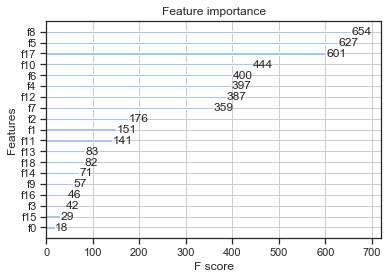

In [83]:
xgmodel = XGBClassifier(random_state = 10)
xgmodel.fit(X_train,y_train)
plot_importance(xgmodel)

In [94]:
finalDf_new.head()

,site_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool
4421367,5,3,4.5,1,2.56,0.035100,5.12,4,0.000485,0,19994,1,37,2,0,1,1,0.071675,0
4081000,5,3,4.5,1,4.06,0.097300,0.00,1,0.000860,0,20551,2,10,2,0,1,1,0.051513,1
9905182,5,4,4.5,1,4.13,0.182500,5.64,24,0.000933,0,9358,3,1,1,0,1,1,0.000641,0
2545111,5,3,5.0,1,1.79,0.122496,4.86,7,0.000662,0,18164,1,21,2,0,1,1,0.226088,0
4011390,5,2,4.0,0,1.61,0.413800,4.18,7,0.000448,0,4522,2,1,1,0,1,1,0.051706,0


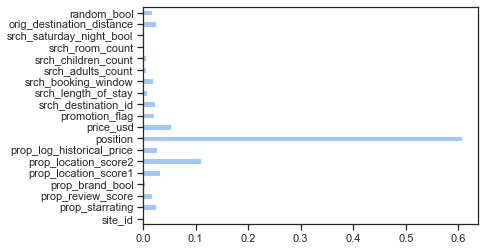

In [96]:
rf = RandomForestClassifier(min_samples_leaf=5,min_samples_split=3,max_depth= 12)
rf.fit(X_train, y_train)
(pd.Series(rf.feature_importances_, index=finalDf_new.columns).plot(kind='barh'))

## Conclusion

In conclusion, most of the models were able to perform fairly well giving an accuracy ranging from 65%-70%. However, there were some models (Boosting, Random Forest) which gave better results in comparison to others (Gaussian NB, Bernoulli NB, Sequential Neural Network).